# <b> Location based Land-Cover Classification Using SENTINEL-2 Imagery and U-Net </b>
# Introduction 
As part of the Final Project for DS1 Univ.ai's Course, the team - RatnaSambhav, Suprit, Jainam, Karthik and Harshetha - started working to build a data pipeline using which year wise land-cover distribution can be obtained for any given location using Sentinel-2 Imageries and deep learning concept of Semantic Segmentation. <br>




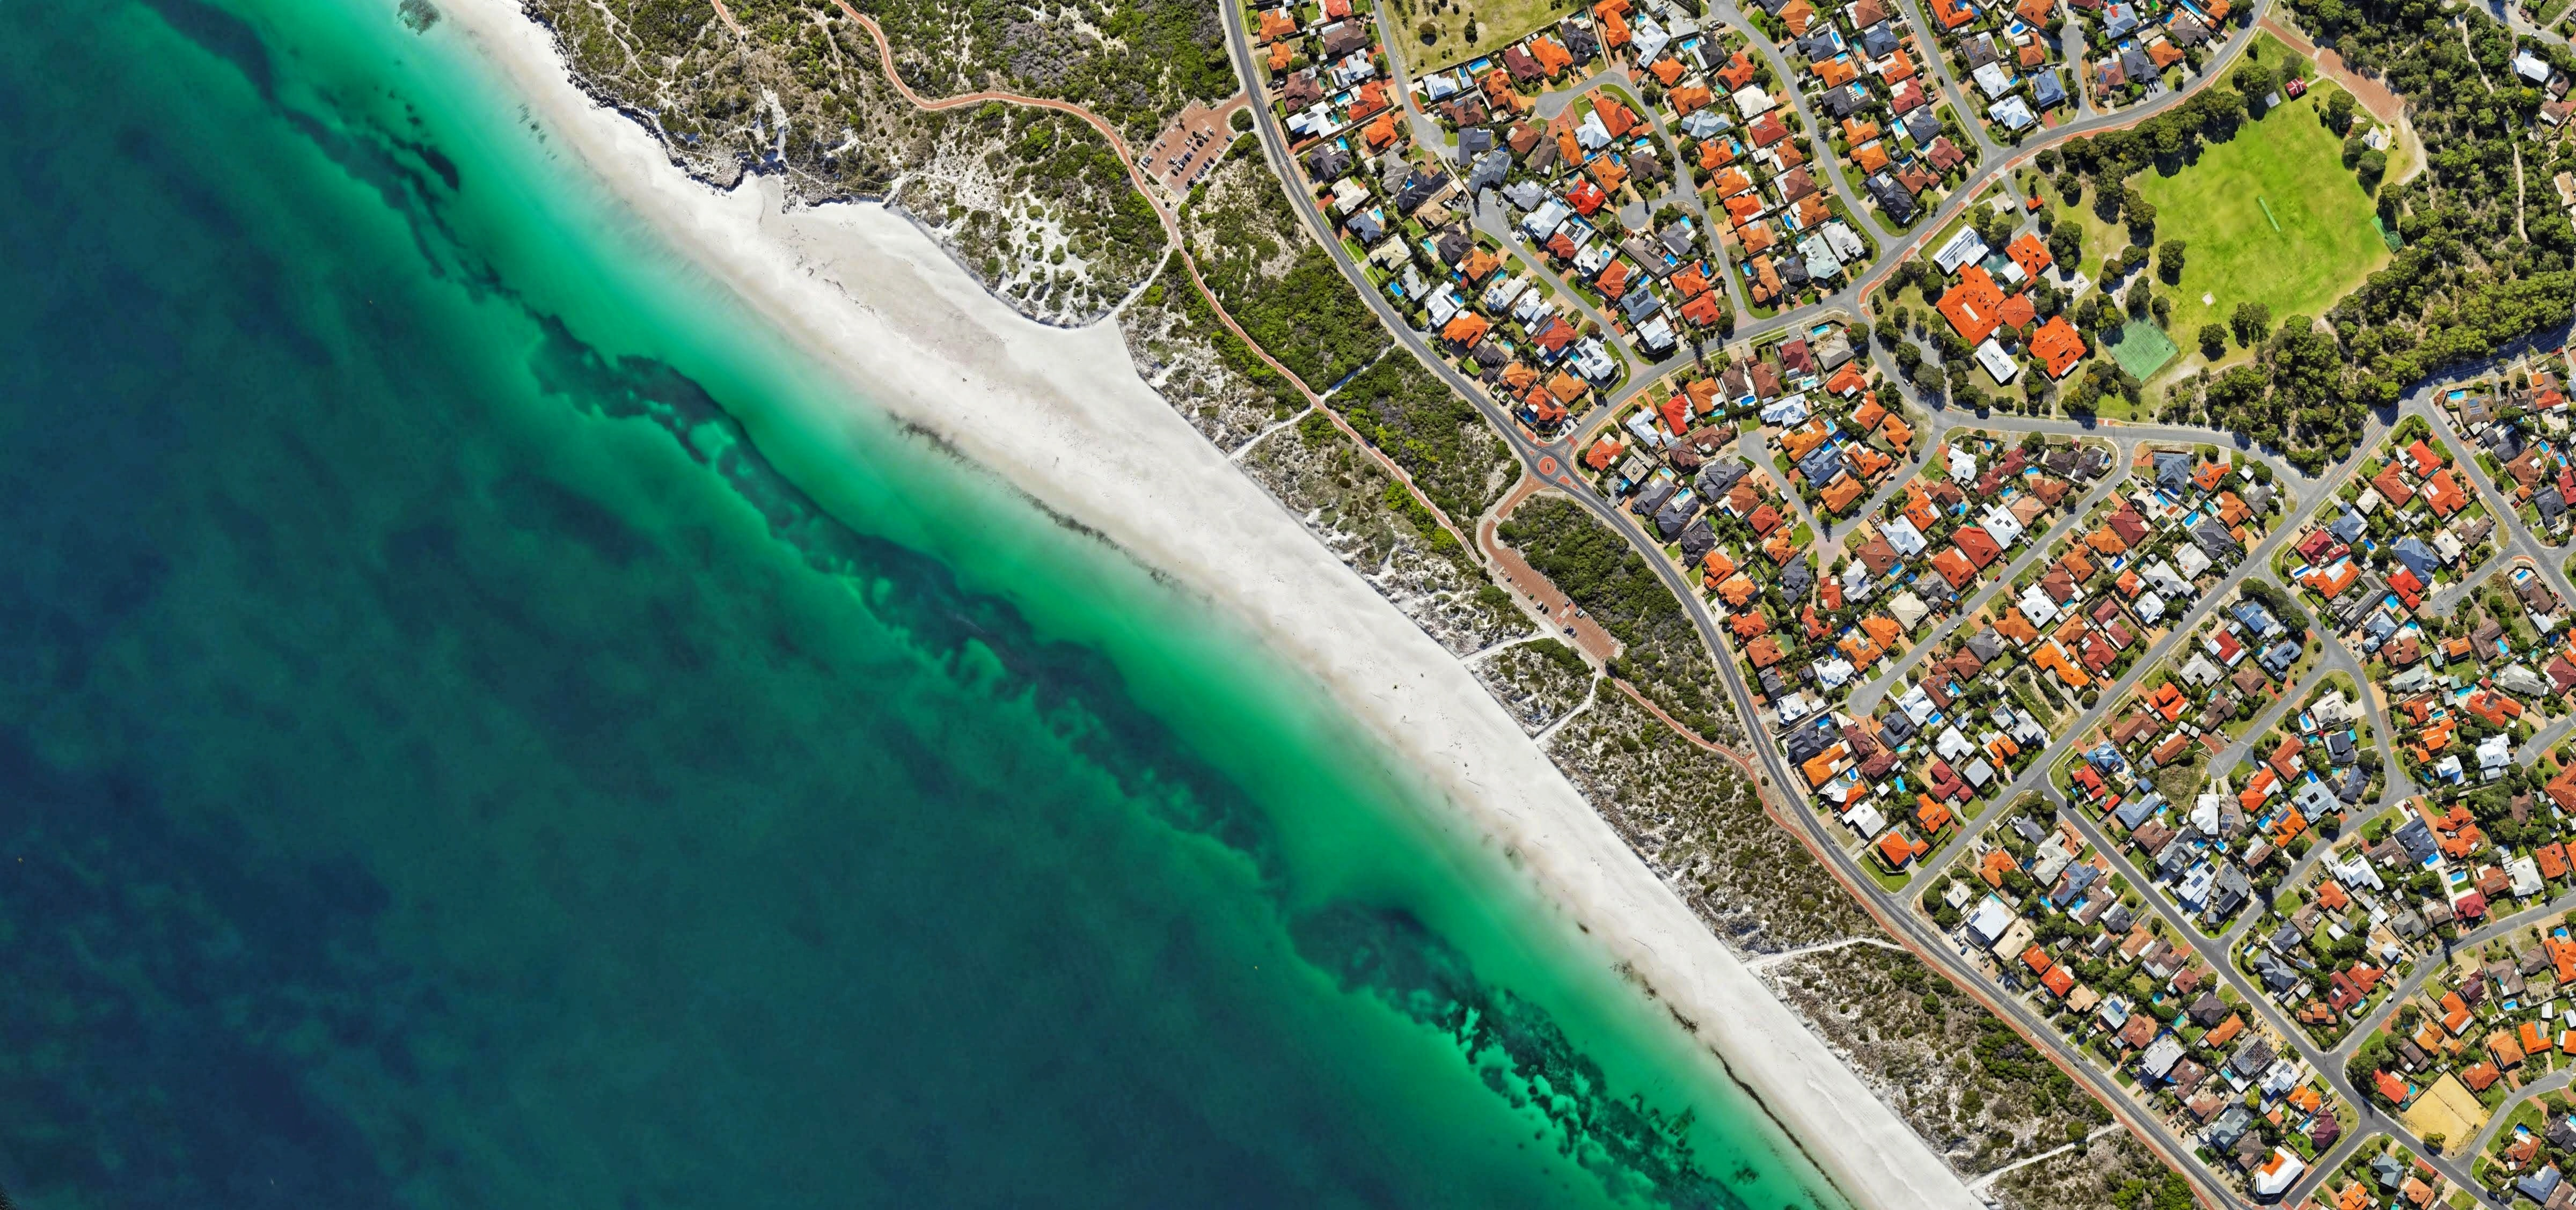










As a starting point towards knowing our environment well, we need to start from our own locality. What has been the rate of urbanization in our area, what is the rate at which trees have been cut down at this location, how much area has been occupied by agricultural land, etc. Asking these questions and knowing its answer will give us a better understanding and help us in strategizing our effort for tree plantation and towards a green environment.


In this project, we are trying to answer questions like what is the distribution of land-use in any given location in 5km by 5km of area, how it was 5 years ago, etc. We are using publicly available satellite SENTINEL-2 for getting our image data with 10m resolution, do a semantic segmentation of our images using our deep learning model having UNet Architecture and then finally getting our year wise land-use dataset, which we are processing before final inferences. Area of a bridge has been taken (Gandhi Setu Bridge, Patna, Bihar) and the reason for taking that particular area is the Ganges river which flows below the bridge varies a lot throughout the year and consequently the agricultural plantation near the shores also changes. But the pipeline has been made in such a way that it can be done for any location. <br>
Basic Steps are:


1.   Getting our Image Data: Set a location, and get images for every month from 2017 onwards.
2.   Cleaning the Data and Getting Predictions from Model: Using pre-trained model (model training explained in other file in the same folder) to get pixel wise prediction and counts of different classes present in the image.
3.   Data Processing and EDA: Cleaning of obtained results dataset and doing EDA.
4.   Inferences, Conclusion and Future Work




# Ground Wrok

#### Import Libraries

In [ ]:
!pip install pystac_client
!pip install shapely
!pip install rioxarray
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 146 kB 7.9 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 2.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.3 MB 9.4 MB/s 
     |████████████████████████████████| 19.3 MB 1.4 MB/s 
  Created wheel for rioxarray: filename=rioxarray-0.9.1-py3-none-any.whl size=54611 sha256=b0c6620e5ee9685e157af5739f27f3d6492e246

In [ ]:
from pystac_client import Client

from shapely.geometry import shape
import pyproj
from shapely.ops import transform
import geopandas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import normalize

import rioxarray
import rasterio
import folium

# Getting our Image Data

## Define a single function which will get the satellite image patch, map and actual image, given lat, long and date.
1. Using pystac client API to access sentinel-2 satellite data collection on aws. 
2. With the input latitude and longitude, firstly a 5km * 5km area is taken around that location. The obtained geometry is then converted to a geoJson file.
3. Using the geometry, API is called and a fullsize satellite image patch (geotiff file) is first extracted for that location.
4. Our geometry file is then also converted to the coordinate reference system same as the satellite image patch and using rasterio.mask, image of the required location is cropped out of that large image patch.
5. Finally, the obtained geotiff file of desired location is converted to rgb image and returned.

In [ ]:
# Function
def get_satellite_img(lat, lon, datetime):

  # Defining url of the aws storage where data is stored
  api_url = "https://earth-search.aws.element84.com/v0"
  client = Client.open(api_url)

  # Setting up the name of the collection we want to access: Sentinel-2, Level 2A, COGs
  collection = "sentinel-s2-l2a-cogs"

  # Creating geometry file from inpiut location and size of area wanted
  km2lat = 1/110.574
  km2lon = 1/(111.320*np.cos(lat*np.pi/180))
  coords = []
  km = 5.12
  coords.append([lon-(km*0.5*km2lon), lat-(km*0.5*km2lat)])
  coords.append([lon+(km*0.5*km2lon), lat-(km*0.5*km2lat)])
  coords.append([lon+(km*0.5*km2lon), lat+(km*0.5*km2lat)])
  coords.append([lon-(km*0.5*km2lon), lat+(km*0.5*km2lat)])
  coords.append([lon-(km*0.5*km2lon), lat-(km*0.5*km2lat)])
  geom = {'type': "Polygon", "coordinates": [coords]}

  # Doing a search of all the satellite patches for that location (not necessarily having 100% intersection) for that date
  # having cloud coverage less than 1%. Then getting the last item from all the obtained patches
  mysearch = client.search(collections=[collection], intersects=geom, datetime=datetime, query=["eo:cloud_cover<1"])
  items = mysearch.get_all_items()
  assets = items[-1].assets

  # Getting the visual (rgb) image of the oatch obtained, and downloading it and saving in .tif format
  visual_href = assets["visual"].href
  visual = rioxarray.open_rasterio(visual_href)
  visual.rio.to_raster("current.tif", driver="COG")
  # Loading the saved .tif pacth image
  data = rasterio.open('/content/current.tif')

  # Getting the coordinate reference system for the data accessed using the API
  dcrs = data.crs

  # Getting rgb layers from the geotif file and bringing in correct order for display
  np_img = data.read([1,2,3])
  patch_img = np.moveaxis(np_img, 0, 2)


  # Projecting the geometry of the area we want into the coordinate refrence system same as that of the obtained patch
  geom_aoi = shape(geom)
  wgs84 = pyproj.CRS('EPSG:4326')
  utm = pyproj.CRS(str(dcrs))
  project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
  utm_point = transform(project, geom_aoi)
  geomk = geopandas.GeoSeries([utm_point])  
  
  # Starting with showing map of the loation asked
  map = folium.Map([lat, lon], zoom_start=14)
  folium.GeoJson(utm_point).add_to(map)
 
  # Follwoing code has been taken from (https://notebooks.githubusercontent.com/view/ipynb?browser=unknown_browser&color_mode=auto&commit=7ffc87bae86867ceef21fbb80e514342054a319a&device=unknown_device&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f7368616b61736f6d2f72732d707974686f6e2d7475746f7269616c732f376666633837626165383638363763656566323166626238306535313433343230353461333139612f52535f507974686f6e2e6970796e62&logged_in=false&nwo=shakasom%2Frs-python-tutorials&path=RS_Python.ipynb&platform=unknown_platform&repository_id=194450692&repository_type=Repository&version=0)
  # Cropping out the desired image area using the transformed geometry file and the patch using rasterio.mask
  # Image is downloaded 
  with rasterio.open("/content/current.tif") as src:
      out_image, out_transform = rasterio.mask.mask(src, geomk, crop=True)
      out_meta = src.meta.copy()
      out_meta.update({"driver": "GTiff",
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform})
  with rasterio.open("RGB_masked2.tif", "w", **out_meta) as dest:
      dest.write(out_image)

  # Loading the geotiff file of our desired area and converting it to numpy array
  # and into the form that can be displayed
  img_tiff = rasterio.open('/content/RGB_masked2.tif')
  np_img = img_tiff.read([1,2,3])
  img = np.moveaxis(np_img, 0, 2)

  return img, patch_img, map

## Set the location and Get images for the given location from Jan, 2016 to Sep, 2022.
1. Getting all the images (5km * 5km) for every month from Jan. 2016 to Sep. 2022 for the input location.
2. Saving all the images for all the dates into a pandas dataframe and saving them in .pkl format.

In [ ]:
## Dubai: 
# lt = 25.1378 
# ln = 55.1272

# Patna Bridge: 
lt=25.6198
ln=85.2043

## A location of Gurugram:
# lt=28.483
# ln=76.93

## Solar Panels:
# lt=24.541388
# ln=55.432222

## Bhadra Solar Park India:
# lt=27+(31/60)+(3/3600)
# ln=71+(55/60)+(45/3600)

In [ ]:
img, patch, map = get_satellite_img(lat=lt, lon=ln, datetime='2017-05-01/2019-06-01')

In [ ]:
print('Have a look at the map of the location')
map

Have a look at the map of the location


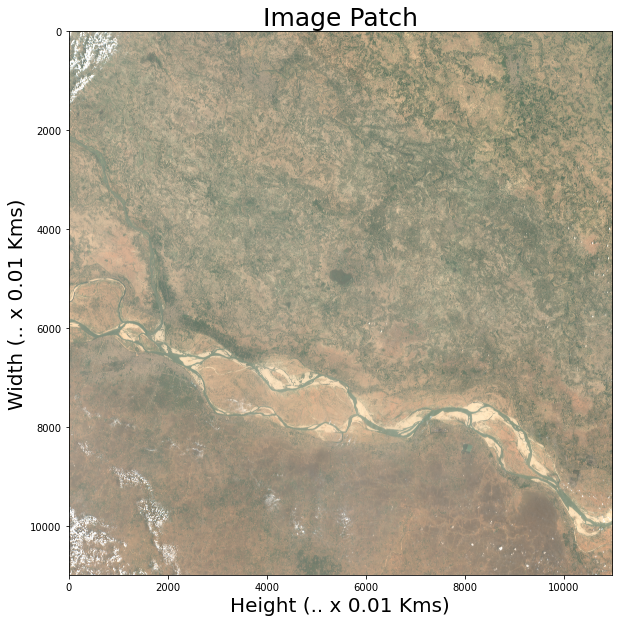

It may look like water but its not. This is shore of Ganges river that is why such a texture. And the shiny lights at the corners are clouds


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(patch)
plt.xlabel('Height (.. x 0.01 Kms)', fontsize=20)
plt.ylabel('Width (.. x 0.01 Kms)', fontsize=20)
plt.title('Image Patch', fontsize=25)
plt.show()
print('It may look like water but its not. This is shore of Ganges river that is why such a texture. And the shiny lights at the corners are clouds')

This is the image we are accessing. You can see the river and the bridge as in the map above.


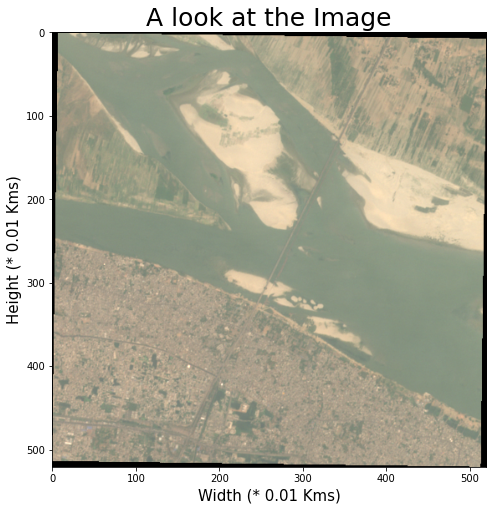

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(img[:, :])
plt.xlabel('Width (* 0.01 Kms)', fontsize=15)
plt.ylabel('Height (* 0.01 Kms)', fontsize=15)
plt.title('A look at the Image', fontsize=25)
print('This is the image we are accessing. You can see the river and the bridge as in the map above.')
plt.show()

In [ ]:
## Getting the dates on per month basis from Jan, 2016 to Sep, 2022
years = ['2016', '2017', '2018', '2019', '2020', '2021', '2022']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

date_list, image_list = [], []
for year in years:
  for month in months:
    start_date = year+ '-' + month+ '-' +'01'
    end_date = year+ '-' + month+ '-' + '28'
    date = start_date+'/'+end_date
    date_list.append(year+ '-' + month)
    print(year+ '-' + month)

    # Try to get the image for this date: If not then fill will NA
    try:
      img, patch, map = get_satellite_img(lat=lt, lon=ln, datetime=date)
      image_list.append(img)
    except:
      image_list.append(None)

2016-01
2016-02
2016-03
2016-04
2016-05
2016-06
2016-07
2016-08
2016-09
2016-10
2016-11
2016-12
2017-01


2017-02


2017-03


2017-04


2017-05


2017-06


2017-07
2017-08
2017-09
2017-10


2017-11


2017-12


2018-01
2018-02


2018-03


2018-04


2018-05


2018-06


2018-07
2018-08
2018-09
2018-10


2018-11


2018-12


2019-01


2019-02


2019-03


2019-04


2019-05


2019-06


2019-07
2019-08
2019-09
2019-10


2019-11


2019-12


2020-01


2020-02


2020-03


2020-04


2020-05


2020-06
2020-07
2020-08


2020-09


2020-10


2020-11


2020-12


2021-01


2021-02


2021-03


2021-04


2021-05


2021-06


2021-07
2021-08
2021-09
2021-10


2021-11


2021-12


2022-01


2022-02


2022-03


2022-04


2022-05


2022-06


2022-07
2022-08


2022-09


2022-10


2022-11
2022-12


In [ ]:
# Creating the dataframe for every image of every date (even including the dates for which image is NA)
df = pd.DataFrame([])
df['Dates'] = date_list[:-3]
df['Images'] = image_list[:-3]

# Saving the dataframe in pickel format, to preserve the datatype
df.to_pickle('/content/drive/MyDrive/Colab Notebooks/DS1/Project/Custom Functions/df.pkl')

# Preparing our Image Dataset and Getting Land-cover Information in Pixel Counts Using Semantic Segmentation with Our Pre-trained UNet Model

## Loading the dataframe, Tiling each image and Filtering the Data.
1. Loading the dataframe saved in .pkl form.
2. Tiling each image to bring them down to 256*256 size, each image covering 2.5km by 2.5km of area. 
3. Filtering each image: Removing undersized images, and black & white images.

#### 1. Loading the dataframe

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/DS1/Project/Custom Functions/df.pkl')
df.tail()

Dates                                             Images
76  2022-05  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
77  2022-06  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
78  2022-07                                               None
79  2022-08  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
80  2022-09  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...

### 2. Iterating through every image in the dataframe and tiling each image to 256*256 size and saving them as new column of the same dataframe

In [ ]:
# Tiling the obtained image in 4 parts so as to get each image 256*256
new_list = []
for i in df.iloc[:,1].values:
  if str(type(i)) != "<class 'NoneType'>":
    img_list = []
    img_list.append(i[:256, :256])
    img_list.append(i[:256, 256:512])
    img_list.append(i[256:512, :256])
    img_list.append(i[256:512, 256:512])
    new_list.append(img_list)
  else:
    new_list.append(None)
df['Img_Tiled'] = new_list

### 3. Filtering the images in the new column: 
 

*   To remove images of inappropriate size (to avoid any error during prediction phase)
*   Eliminating the images which is black and white (occuring when there is no intersection between obatined satellite image and geometry of the area wanted).

In [ ]:
# Filtering the image: Removing images of different sizes and also removing images containing binary colors only
tiled_img = []
for i in df['Img_Tiled'].values:
  if str(type(i)) != "<class 'NoneType'>":
    img_list = []
    for img in i:
      # Checking if the number of unique values in the image is less than 100, it will most probably be not a good image
      # Also choosing only the desired size and removing others.
      if img.shape == (256, 256, 3) or len(np.unique(img)) > 100:
        img_list.append(img)
      else:
        img_list.append(None)
    tiled_img.append(img_list)
  else:
    tiled_img.append(None)
df['Img_Tiled_Filtered'] = tiled_img

## Predicting for each image in the dataframe using the model and saving the results in a dataframe
1. Loading the pre-trained model
2. Predicting using the model:
> *   For every date, predict and get the land-type in pixel counts for all the four images.
> *   Taking the sum of pixel class counts for all the four images of that area.
3. Finally saving in a pandas dataframe.









#### 1. Loading the pre-trained model

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import normalize

# Loading the pre-trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/DS1/Project/Custom Functions/model.h5')

#### 2. Predicting the land-type using the model: 


*   Accessing each image from the dataframe and normalizing them before inputting for model prediction.
*   Using np.argmax for every pixel to get the class having highest probability for that pixel.
*   Calculating total sum of counts of every class that model predicted for all the pixels of that image using np.unique.
*   Getting the class count for the whole 5km by 5km area (original untiled image).



In [ ]:
class_dict = []
for image_list in df['Img_Tiled_Filtered'].values:
  if str(type(image_list)) != "<class 'NoneType'>":
    image_class_list = []
    for image in image_list:
      if str(type(image)) != "<class 'NoneType'>":
        img = np.expand_dims(normalize(image), axis=0)
        pred = model.predict(img)
        class_pred = np.argmax(pred[0,:,:,:], axis=2)
        classes, count = np.unique(class_pred, return_counts=True)[0], np.unique(class_pred, return_counts=True)[1]
        image_class_list.append([[i,0] if (i not in classes) else [i,count[np.where(classes==i)[0][0]]] for i in range(7)])
      else:
        image_class_list.append([[0, 0], [1, 0], [2, 0], [3, 0], [4, 0], [5, 0]])
      mean = np.mean(np.array(image_class_list), axis=0)
    class_dict.append(mean)
  else:
    class_dict.append(None)

1/1 [==============================] - 0s 157ms/step


#### 3. Saving in the form of pandas dataframe.

In [ ]:
final_df = pd.DataFrame([])
final_df['Dates'] = df['Dates']
final_df['Urban'] = [None if str(i)=='None' else i[1][1] for i in class_dict]
final_df['Agriculture'] = [None if str(i)=='None' else i[2][1] for i in class_dict]
final_df['Rangeland'] = [None if str(i)=='None' else i[3][1] for i in class_dict]
final_df['Forest'] = [None if str(i)=='None' else i[4][1] for i in class_dict]
final_df['Water'] = [None if str(i)=='None' else i[5][1] for i in class_dict]
final_df['BarrenLand'] = [None if str(i)=='None' else i[6][1] for i in class_dict]
final_df['Others'] = [None if str(i)=='None' else i[0][1] for i in class_dict]

final_df.tail()

Dates     Urban  Agriculture  Rangeland  Forest     Water  BarrenLand  \
76  2022-05   9557.50       622.75    3183.75   66.50  51380.25       698.5   
77  2022-06   1016.00       877.00    1442.75  214.00  55564.25      6415.0   
78  2022-07       NaN          NaN        NaN     NaN       NaN         NaN   
79  2022-08  33826.25     21919.25       7.25   70.25   2452.00      6951.0   
80  2022-09  40533.50     15302.50       7.25   71.25   3448.75      5418.0   

    Others  
76   26.75  
77    7.00  
78     NaN  
79  310.00  
80  754.75

In [ ]:
final_df.to_csv('/content/drive/MyDrive/Colab Notebooks/DS1/Project/Custom Functions/final_df.csv')

# Data Processing: Results


1.   Loading the dataset
2.   Detecting Outliers Using Dimensionality Reduction and Clustering
3.   Imputing All the NaN values
4.   Exploratory Data Analysis
5.   Saving the Final Processed Dataset into our Memory



## Loading And Imputing All the NaN values and replacing Outlier Values with KNNImputer

#### Loading the Dataset and Removing the Values for year 2016

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS1/Project/Custom Functions/final_df.csv', index_col=0)

# Dropping the first 12 months belonging to year 2016 (since mostly sentinel 2 does not have images for 2016)
df = df.drop([i for i in range(12)], axis=0)
df.reset_index(inplace=True, drop=True)
df.head(10)

Dates     Urban  Agriculture  Rangeland   Forest     Water  BarrenLand  \
0  2017-01  25538.75     11895.75    5142.75    58.75  22470.75      429.25   
1  2017-02   1125.75     15034.00    5482.50  2579.75  40814.25      499.50   
2  2017-03   1464.00      6937.00    4126.25  5141.75  46074.50     1792.50   
3  2017-04   2088.00      1815.50     247.75    49.75  56521.00     4814.00   
4  2017-05   1262.00        13.00      76.25     4.25  63839.50      341.00   
5  2017-06   4801.75      1110.00    3563.50   138.50  53057.25     2865.00   
6  2017-07       NaN          NaN        NaN      NaN       NaN         NaN   
7  2017-08       NaN          NaN        NaN      NaN       NaN         NaN   
8  2017-09       NaN          NaN        NaN      NaN       NaN         NaN   
9  2017-10   1711.50       616.25    2655.50   195.00  59938.25      419.50   

   Others  
0    0.00  
1    0.25  
2    0.00  
3    0.00  
4    0.00  
5    0.00  
6     NaN  
7     NaN  
8     NaN  
9    0.00

#### Dropping All the NaN values from the Dataset
We will impute these NaN values later after we remove the outliers

In [ ]:
df_copy = df.copy()
df.dropna(inplace=True)
df.isna().sum()

Dates          0
Urban          0
Agriculture    0
Rangeland      0
Forest         0
Water          0
BarrenLand     0
Others         0
dtype: int64

### Checking on Outliers using KMeans clustering on TSNE based Dimensionally Reduced Dataset <br>
We used <b>TSNE</b> because we have to detect data points based on their <b>closeness</b> to each other. The datapoints which will lie far away will surely be an outlier.
<br> And <b>KMneas clustering</b> gave us power to separate the outliers from the main datapoints.

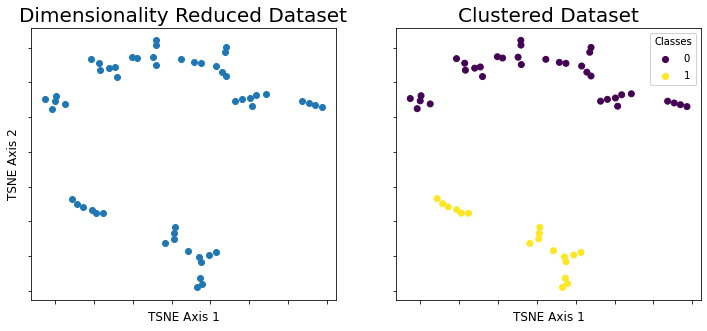

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler().fit_transform(df.drop(['Dates'], axis=1)
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, random_state=41).fit_transform(df.drop(['Dates'], axis=1))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax[0].scatter(X_embedded[:,0], X_embedded[:,1])
ax[0].axes.xaxis.set_ticklabels([])
ax[0].axes.yaxis.set_ticklabels([])
ax[0].set_title('Dimensionality Reduced Dataset', fontsize=20)
ax[0].set_xlabel('TSNE Axis 1', fontsize=12)
ax[0].set_ylabel('TSNE Axis 2', fontsize=12)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_embedded)
scatter = ax[1].scatter(X_embedded[:,0], X_embedded[:,1], c=kmeans.labels_)
legend1 = ax[1].legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax[1].add_artist(legend1)
ax[1].axes.xaxis.set_ticklabels([])
ax[1].axes.yaxis.set_ticklabels([])
ax[1].set_title('Clustered Dataset', fontsize=20)
ax[1].set_xlabel('TSNE Axis 1', fontsize=12)
ax[1].set_xlabel('TSNE Axis 1', fontsize=12)
plt.show()

### Replacing outliers with NaN values
This is done so that later we can impute these NaN values, resulting finally in replacing the outliers with realizable data points based on Date. <br>
<b> This happens because </b> our semantic segmentation model is not highly accurate, thus it gives bad results in many cases. If the area has greenery increasing or urban land increasing, then we have to replace these incorrect values with the values which are also in increasing order based on date. <br>
Hence, KNN imputer is the best choice in this case.<br>


*   We first remove these outliers with NaN values.
*   Then we impute all the NaN values based on KNN imputer, to preserve local trend.



In [ ]:
df['cluster'] = kmeans.labels_
df_cluster_corrected = df.copy()
for i in range(len(df_cluster_corrected)):
  if df_cluster_corrected['cluster'].values[i] == 1:
    df_cluster_corrected.iloc[i] = [df_cluster_corrected['Dates'].values[i], np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
df_cluster_corrected.drop(['cluster'], axis=1, inplace=True)
df_cluster_corrected.reset_index(inplace=True, drop=True)
df_cluster_corrected.head()

Dates     Urban  Agriculture  Rangeland   Forest     Water  BarrenLand  \
0  2017-01  25538.75     11895.75    5142.75    58.75  22470.75      429.25   
1  2017-02   1125.75     15034.00    5482.50  2579.75  40814.25      499.50   
2  2017-03   1464.00      6937.00    4126.25  5141.75  46074.50     1792.50   
3  2017-04       NaN          NaN        NaN      NaN       NaN         NaN   
4  2017-05       NaN          NaN        NaN      NaN       NaN         NaN   

   Others  
0    0.00  
1    0.25  
2    0.00  
3     NaN  
4     NaN

In [ ]:
# Performing KNN Imputation for all the NaN values (initially outliers)
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=4, missing_values=np.nan)
imputed_df = imputer.fit_transform(df_cluster_corrected.drop(['Dates'], axis=1))
imputed_df = pd.DataFrame(imputed_df, columns = ['Urban',	'Agriculture',	'Rangeland',	'Forest',	'Water',	'BarrenLand',	'Others'])
imputed_df = pd.concat([df_cluster_corrected.Dates, imputed_df], axis=1)
imputed_df.head()

Dates     Urban   Agriculture    Rangeland   Forest         Water  \
0  2017-01  25538.75  11895.750000  5142.750000    58.75  22470.750000   
1  2017-02   1125.75  15034.000000  5482.500000  2579.75  40814.250000   
2  2017-03   1464.00   6937.000000  4126.250000  5141.75  46074.500000   
3  2017-04  17199.45  11756.342857  2666.478571   717.30  30654.514286   
4  2017-05  17199.45  11756.342857  2666.478571   717.30  30654.514286   

    BarrenLand     Others  
0   429.250000   0.000000  
1   499.500000   0.250000  
2  1792.500000   0.000000  
3  2485.221429  56.692857  
4  2485.221429  56.692857

### Merging our Imputed Dataset with the main Dataset and Performing Imputation on Remaining NaNs
So that we will get land-cover data for each and every month.

In [ ]:
final_df = pd.DataFrame([], columns=['Dates', 'Urban',	'Agriculture',	'Rangeland',	'Forest',	'Water',	'BarrenLand',	'Others'])
for i,date in enumerate(df_copy.Dates.values):
  if date in imputed_df.Dates.values:
    final_df.loc[i,:] = list(imputed_df[imputed_df['Dates']==date].values[0])
  else:
    final_df.loc[i,:] = [date, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

final_df.head(10)

Dates     Urban   Agriculture    Rangeland   Forest         Water  \
0  2017-01  25538.75      11895.75      5142.75    58.75      22470.75   
1  2017-02   1125.75       15034.0       5482.5  2579.75      40814.25   
2  2017-03    1464.0        6937.0      4126.25  5141.75       46074.5   
3  2017-04  17199.45  11756.342857  2666.478571    717.3  30654.514286   
4  2017-05  17199.45  11756.342857  2666.478571    717.3  30654.514286   
5  2017-06  17199.45  11756.342857  2666.478571    717.3  30654.514286   
6  2017-07       NaN           NaN          NaN      NaN           NaN   
7  2017-08       NaN           NaN          NaN      NaN           NaN   
8  2017-09       NaN           NaN          NaN      NaN           NaN   
9  2017-10  17199.45  11756.342857  2666.478571    717.3  30654.514286   

    BarrenLand     Others  
0       429.25        0.0  
1        499.5       0.25  
2       1792.5        0.0  
3  2485.221429  56.692857  
4  2485.221429  56.692857  
5  2485.221429  56.692857  
6          NaN        NaN  
7          NaN        NaN  
8          NaN        NaN  
9  2485.221429  56.692857

In [ ]:
# Peforming KNN Imputation again: For the NaN values which happended because there was no satellite image for that month
imputer = KNNImputer(n_neighbors=4, missing_values=np.nan)
final_imputed_df = imputer.fit_transform(final_df.drop(['Dates'], axis=1))
final_imputed_df = pd.DataFrame(final_imputed_df, columns = ['Urban',	'Agriculture',	'Rangeland',	'Forest',	'Water',	'BarrenLand',	'Others'])
final_imputed_df = pd.concat([df_copy.Dates, final_imputed_df], axis=1)
final_imputed_df.head()

Dates     Urban   Agriculture    Rangeland   Forest         Water  \
0  2017-01  25538.75  11895.750000  5142.750000    58.75  22470.750000   
1  2017-02   1125.75  15034.000000  5482.500000  2579.75  40814.250000   
2  2017-03   1464.00   6937.000000  4126.250000  5141.75  46074.500000   
3  2017-04  17199.45  11756.342857  2666.478571   717.30  30654.514286   
4  2017-05  17199.45  11756.342857  2666.478571   717.30  30654.514286   

    BarrenLand     Others  
0   429.250000   0.000000  
1   499.500000   0.250000  
2  1792.500000   0.000000  
3  2485.221429  56.692857  
4  2485.221429  56.692857

### Converting Pixel Counts to Percentage and Rounding off

In [ ]:
# Converting land-cover pixel count into percentage and rounding off to 2nd decimal places
final_imputed_df[['Urban',	'Agriculture',	'Rangeland',	'Forest',	'Water',	'BarrenLand',	'Others']] = final_imputed_df.drop(['Dates'], axis=1)*100/65536
final_imputed_df[['Urban',	'Agriculture',	'Rangeland',	'Forest',	'Water',	'BarrenLand',	'Others']] = final_imputed_df[['Urban',	'Agriculture',	'Rangeland',	'Forest',	'Water',	'BarrenLand',	'Others']].round(decimals = 2)
final_imputed_df.head()

Dates  Urban  Agriculture  Rangeland  Forest  Water  BarrenLand  Others
0  2017-01  38.97        18.15       7.85    0.09  34.29        0.65    0.00
1  2017-02   1.72        22.94       8.37    3.94  62.28        0.76    0.00
2  2017-03   2.23        10.59       6.30    7.85  70.30        2.74    0.00
3  2017-04  26.24        17.94       4.07    1.09  46.78        3.79    0.09
4  2017-05  26.24        17.94       4.07    1.09  46.78        3.79    0.09

## Exploratory Data Analysis

In [ ]:
# Calculating mean and variance in the final dataset
mean = [np.mean(final_imputed_df[i].values) for i in final_imputed_df.columns[1:]]
variance = [np.std(final_imputed_df[i].values) for i in final_imputed_df.columns[1:]]

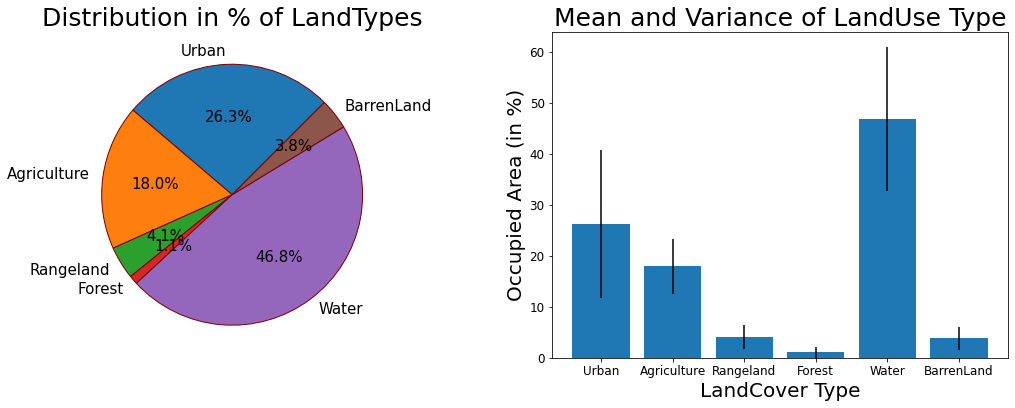

In [ ]:
# Plottig for better visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
ax[0].pie(mean[:-1], labels=final_imputed_df.columns[1:-1], autopct='%.1f%%', wedgeprops={'edgecolor':'maroon'}, \
          textprops = {"fontsize":15}, startangle=45)
ax[0].set_title('Distribution in % of LandTypes', fontsize=25)
ax[1].bar(final_imputed_df.columns[1:-1], mean[:-1], yerr=variance[:-1])
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_xlabel('LandCover Type', fontsize=20)
ax[1].set_ylabel('Occupied Area (in %)', fontsize=20)
ax[1].set_title('Mean and Variance of LandUse Type', fontsize=25)
plt.show()

### Checking the Data for Noise and Taking Moving Average
The area we have taken (Patna Bridge) has variation in water in the river as well as agricluture (due to flood in the river). There is a seasonal variation. So our data should reflect that, but we also have to avoid the noise due to prediction from our not-so-accurate model. So, we implemented a moving average which take average for every 4 months.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24,6))

# Plotting noisy data
for i in final_imputed_df.columns[1:-1]:
  ax[0].plot(final_imputed_df['Dates'], final_imputed_df[i], linewidth=3, label=i)
ax[0].legend()
ax[0].axes.xaxis.set_ticklabels([])
ax[0].set_title('Noise in the Data', fontsize=20)
ax[0].set_xlabel('Time (in Months)', fontsize=15)
ax[0].set_ylabel('Area Acquired (in %)', fontsize=15)

# Creating a new dataframe after applying moving average to our original dataset and plotting the results
final_imputed_df_averaged = final_imputed_df.copy()
for land_type in final_imputed_df.columns[1:]:
  final_imputed_df_averaged[land_type] = final_imputed_df[land_type].rolling(4).mean()
final_imputed_df_averaged.drop([0,1,2], inplace=True)

for i in final_imputed_df.columns[1:-1]:
  ax[1].plot(final_imputed_df_averaged['Dates'], final_imputed_df_averaged[i], linewidth=3, label=i)
ax[1].legend()
ax[1].axes.xaxis.set_ticklabels([])
ax[1].set_title('Noise in the Data After Averaging', fontsize=20)
ax[1].set_xlabel('Time (in Months)', fontsize=15)
ax[1].set_ylabel('Area Acquired (in %)', fontsize=15)

plt.show()

## Saving our Final DataSet

In [ ]:
final_imputed_df_averaged.to_csv('/content/drive/MyDrive/Colab Notebooks/DS1/Project/Custom Functions/processed_final_df.csv')

# Getting Insights from Our Data through Interactive Visualization

#### Loading the dataset

In [ ]:
df_for_plot = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS1/Project/DS1 Project Submission/processed_final_df.csv', index_col=0)
df_for_plot.head()

Dates    Urban  Agriculture  Rangeland  Forest    Water  BarrenLand  \
3  2017-04  17.2900      17.4050     6.6475  3.2425  53.4125      1.9850   
4  2017-05  14.1075      17.3525     5.7025  3.4925  56.5350      2.7700   
5  2017-06  20.2375      16.1025     4.6275  2.7800  52.6600      3.5275   
6  2017-07  26.2400      17.9400     4.0700  1.0900  46.7800      3.7900   
7  2017-08  26.2400      17.9400     4.0700  1.0900  46.7800      3.7900   

   Others  
3  0.0225  
4  0.0450  
5  0.0675  
6  0.0900  
7  0.0900

#### Grouping Based On Year

In [ ]:
# Removing month info from dates and grouping
df_for_plot['Dates'] = [i[:4] for i in df_for_plot['Dates']]
df_for_plot_grouped = df_for_plot.groupby('Dates').mean()
# Rounding off to two digits
df_for_plot_grouped[['Urban',	'Agriculture',	'Rangeland',	'Forest',	'Water',	'BarrenLand',	'Others']] = \
df_for_plot_grouped[['Urban',	'Agriculture',	'Rangeland',	'Forest',	'Water',	'BarrenLand',	'Others']].round(decimals = 2)
df_for_plot_grouped

Urban  Agriculture  Rangeland  Forest  Water  BarrenLand  Others
Dates                                                                  
2017   23.23        17.61       4.60    1.78  49.25        3.45    0.08
2018   22.35        16.20       4.41    1.00  51.59        4.39    0.06
2019   26.69        16.68       4.00    1.17  48.13        3.28    0.05
2020   27.24        16.75       4.04    0.81  47.41        3.61    0.13
2021   26.90        19.83       4.01    0.88  44.71        3.63    0.04
2022   28.23        19.91       3.24    0.95  43.38        4.19    0.10

#### Making our Dashboard

In [ ]:
import plotly.graph_objects as px

In [ ]:
## Following codes are taken and modified from https://www.geeksforgeeks.org/how-to-make-dropdown-menus-in-plotly/
landtype = ['Urban',	'Agriculture',	'Rangeland',	'Forest',	'Water',	'BarrenLand',	'Others']

fig_list = []
for land in landtype:
  fig_list.append(px.Bar(name = land, x = df_for_plot_grouped.index.values, y = df_for_plot_grouped[land]))
plot = px.Figure(data=fig_list)

# Drop down buttons list
butn_list = []
butn_list.append(dict(label="All ", method="update", args=[{"visible": [True, True, True, True, True, True]}, {"title": "Area Occupied By Different LandTypes (in %)",}]))
for land in landtype:
  butn_list.append(dict(label=land, method="update", args=[{"visible": [True if i==land else False for i in landtype]}, {"title": "Area occupied by "+land+" (%)",}]))

# Add dropdown
plot.update_layout(
	updatemenus=[
		dict(
			active=0,
			buttons=list(butn_list),
		)
	])

plot.update_layout(
    title="Area occupied by Different LandTypes",
    xaxis_title="LandTypes",
    yaxis_title="Area Occupied (%)",
    legend_title="Different Nutrients",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

plot.show()


# Inference, Conclusion and Future Work

## Looking at the Image and the Results

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
ax[0].pie(mean[:-1], labels=final_imputed_df.columns[1:-1], autopct='%.1f%%', wedgeprops={'edgecolor':'maroon'}, \
          textprops = {"fontsize":15}, startangle=45)
ax[0].set_title('Distribution in % of LandTypes', fontsize=25)

ax[1].imshow(img[:, :])
ax[1].set_xlabel('Width (* 0.01 Kms)', fontsize=15)
ax[1].set_ylabel('Height (* 0.01 Kms)', fontsize=15)
ax[1].set_title('A look at the Image', fontsize=20)
plt.show()

## <b>Inferences</b>

As it appears from the above image, our classification model has predicted all of the pixels almost correctly. It is visible that water, urban area and agriculture are the most dominant classes in the given image. <br>
Problem is that in the last 5-6 years there have not been much changes in this area (or in any other area in the world), so we can't get real power of the developed model and the data pipeline. However, this can be a really good asset when this pipeline is applied on images acquired from premium satellites which have higher image resolution, thus can detect any minute changes in the land-cover. 

## **Conclusion and Improvements**

For the given location, in the past 5-6 years, there haven't been much change like urban expansion, deforestation/afforestation, etc. In fact, its hard to find places, where just in 5-6 years there are considerable changes in land-use. Also, the SENTINEL program started in 2016, so we are restricted to years after that. If we go to LANDSAT satellite images, its resolution in 30m and can never be used for semantic segmentation or classification. <br>
But overall, the performance of our model is good enough, as the mean value of percentage land-use is almost correct as it appears from the above images. <br>
The places where improvement can be done is training our model on more and more images (we tried labelling our own dataset but due to time constraints didn't continue with that). Also, there can be some improvement in how we are accessing the data. We can use a model for cloud detection in images and filter images based on cloud cover too. These work will surely improve our results but the major constrain is the quality of image. SENTINEL-2 gives 10m resolution, thus any change in land-use which is below the size of 100m^2 wont be even visible. Thus, with better satellite images, our model and pipeline can be very useful.  